In [137]:
import numpy as np
from collections import OrderedDict as odict
import pandas as pd
import matplotlib.pyplot as plt

In [138]:
#(hardware name, number of nodes, plotstyle)
filesD = {'knl_mpi1':('knl',1,'g.'), 'knl_mpi2':('knl',2,'g*'), 'knl_mpi4':('knl',4,'g+'),
         'skl_mpi1':('skl',1,'b.'), 'skl_mpi2':('skl',2,'b*'), 'skl_mpi4':('skl',4,'b+'),
         'p100_mpi1':('p100',1,'r.'), 'p100_mpi2':('p100',2,'r*'), 'p100_mpi4':('p100',4,'r+'),
         'v100_mpi1':('v100',1,'y.'), 'v100_mpi2':('v100',2,'y*'), 'v100_mpi4':('v100',4,'y+'),
         'i5':('i5',1,'m.'),'gtx1060':('gtx1060',1,'k.')
             }
# order by number of nodes to make labeling easier further down
files = odict(sorted(filesD.items(), key= lambda t : t[1][1]))
# count number of 1 nodes in dict
number=0
for k,v in files.items(): 
    if v[1]==1: number+=1

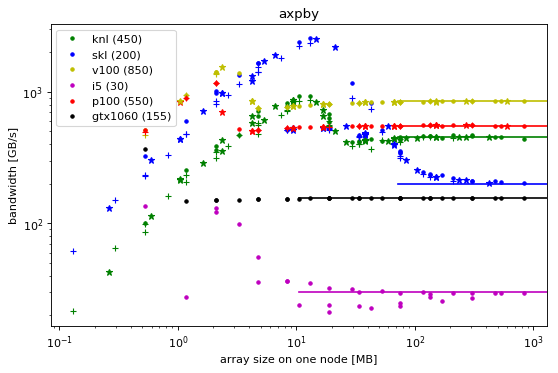

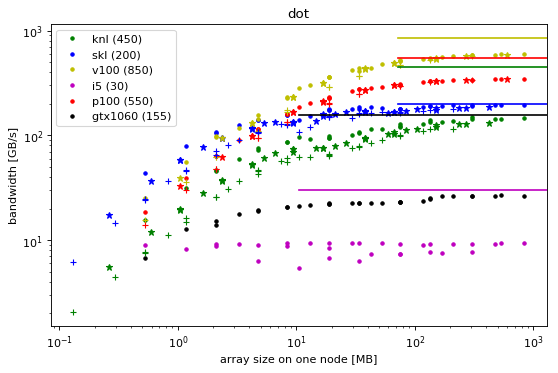

In [170]:
for q in ('axpby','dot'):
    fig,ax=plt.subplots(1,1,figsize=(8,5),dpi= 80, facecolor='w', edgecolor='k')
    for f, v in files.items():  
        #read in csv file
        df=pd.read_csv('benchmark_'+f+'.csv', delimiter=' ')
        #add size and get rid of non-relevant columns
        df.insert(0,'size', 8*df['n']*df['n']*df['Nx']*df['Ny']/1e6/v[1])
        bw = df[['n','Nx','Ny','size']]
        bw = bw.assign(axpby = df['size']/1000*3/df['axpby'])
        bw = bw.assign(dot = df['size']/1000*2/df['dot'])
        #compute mean and standard derivation of 'same' groups 
        bw=bw.groupby(['n', 'Nx','Ny','size']).agg(['mean', 'std'])
        bw=bw.reset_index(level=['n','Nx','Ny','size'])
        bw=bw.sort_values(by='size')
        bw[q].plot(ax=ax,style=v[2],x=bw.loc[:,'size'],y='mean',label=v[0])
    plt.xlabel('array size on one node [MB]')
    plt.ylabel('bandwidth [GB/s]')
    plt.xscale('log')
    plt.yscale('log')
    bw=[450,200,850,30,550,155]
    plt.axhline(y=bw[0],xmin=0.7,xmax=1,color='g')
    plt.axhline(y=bw[1],xmin=0.7,xmax=1,color='b')
    plt.axhline(y=bw[2],xmin=0.7,xmax=1,color='y')
    plt.axhline(y=bw[3],xmin=0.5,xmax=1,color='m')
    plt.axhline(y=bw[4],xmin=0.7,xmax=1,color='r')
    plt.axhline(y=bw[5],xmin=0.5,xmax=1,color='k')

    handles, labels = plt.gca().get_legend_handles_labels()
    for i in range(number):
        labels[i]=labels[i]+' ('+str(bw[i])+')'
    hanles = handles[0:number]; labels = labels[0:number]
    plt.legend(handles, labels, loc='upper left')
    plt.title(q)

'+' are 4 nodes, '*' are 2 nodes, 'dots' are 1 node

##### Conclusions
- meaningful values start at 10MB (especially in Skylake the cache effect in axpby is obvious: without communication vector just stays in cache of size 33MB )
- total problem size on one node in both axpby and dot is 2 * array size
- size normalization for MPI reveals that it is indeed the single node bandwidth that counts, (if we simply divided bandwidth by # of nodes, we would falsely attribute performance loss to MPI communication)
- for small sizes the communication overhead in MPI becomes visible
- Skylake achieves almost 100% efficiency in dot product, followed by Tesla cards P100 and V100
